In [0]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Network models

In [0]:
from tensorflow.keras.layers import Layer, LSTM, Maximum, Concatenate, Dense, GRU, Embedding, Dropout

### Simple k=1 classification models

In [0]:
# one-hot 2-directional GRU classification model with k=1

class oh2GRUp_whole_text (Layer):
    
    def __init__(self, units=256, nb_classes=2):
        super(oh2GRUp_whole_text, self).__init__()
        
        # forward GRU layer
        self.forward = GRU(units, return_sequences=True)
        # backwards GRU layer
        self.backward = GRU(units, return_sequences=True, go_backwards=True)
        # concatenation
        self.concat = Concatenate(axis=1)
        # dropout
        self.dropout = Dropout(0.1)
        # top dense layer
        self.dense = Dense(nb_classes, activation='softmax')
        
        
    def call(self, x):     
        y1 = self.forward(x)
        y2 = self.backward(x)

        # total maxpooling since k=1
        maxForward = tf.reduce_max(y1, axis=1)
        maxBackward = tf.reduce_max(y2, axis=1)

        concatenated = self.concat([maxForward, maxBackward])
        return self.dense(self.dropout(concatenated))

In [0]:
# one-hot 2-directional LSTM classification model with k=1

class oh2LSTMp_whole_text(Layer):
    
    def __init__(self, units=512, nb_classes=2):
        super(oh2LSTMp_whole_text, self).__init__()

        # forward GRU layer
        self.forward = LSTM(units, return_sequences=True)
        # backwards GRU layer
        self.backward = LSTM(units, return_sequences=True, go_backwards=True)
        # concatenation
        self.concat = Concatenate(axis=1)
        # dropout
        self.dropout = Dropout(0.4)
        # top dense layer
        self.dense = Dense(nb_classes, activation='softmax')
        
        
    def call(self, x):
        y1 = self.forward(x)
        y2 = self.backward(x)

        # total maxpooling since k=1
        maxForward = tf.reduce_max(y1, axis=1)
        maxBackward = tf.reduce_max(y2, axis=1)

        concatenated = self.concat([maxForward, maxBackward])
        return self.dense(self.dropout(concatenated))
    

### k!=1 models

In [0]:
# one-hot 2-directional LSTM binary classification model with k!=1

class oh2LSTMp_k_regions(Layer):
    
    def __init__(self, k, units=256, nb_classes=2):
        super(oh2LSTMp_k_regions, self).__init__()

        self.nb_classes = nb_classes
        self.k = k

        self.forward = LSTM(units, return_sequences=True)
        self.backward = LSTM(units, return_sequences=True, go_backwards=True)
        self.concat = Concatenate(axis=1)
        self.dropout = Dropout(0.4)
        self.dense = Dense(self.nb_classes, activation='softmax')
        
    def call(self, x):
        y1 = self.forward(x)
        y2 = self.backward(x)

        # split text regions
        y1 = [tf.split (y, [int(y1.shape[1]/(self.k))]*int(self.k) + [y1.shape[1]-int(y1.shape[1]/self.k)*int(self.k)], axis=0)[:-1] for y in y1]
        # regional maxpooling (region embedding)
        maxForward = tf.reshape(tf.reduce_max(y1, axis=2), shape=(len(y1),-1))

        # split text regions
        y2 = [tf.split (y, [int(y2.shape[1]/(self.k))]*int(self.k) + [y2.shape[1]-int(y2.shape[1]/self.k)*int(self.k)], axis=0)[:-1] for y in y2]
        # regional maxpooling (region embedding)
        maxBackward = tf.reshape(tf.reduce_max(y2, axis=2), shape=(len(y2), -1))
        
        concatenated = self.concat([maxForward, maxBackward])What Is IMAP?
        return self.dense(self.dropout(concatenated))

In [0]:
# one-hot 2-directional LSTM binary classification model with k!=1

class oh2GRUp_k_regions(Layer):
    
    def __init__(self, k, units=128, nb_classes=2):
        super(oh2GRUp_k_regions, self).__init__()

        self.nb_classes = nb_classes
        self.k = k

        self.forward = GRU(units, return_sequences=True)
        self.backward = GRU(units, return_sequences=True, go_backwards=True)
        self.concat = Concatenate(axis=1)
        self.dropout = Dropout(0.4)
        self.dense = Dense(self.nb_classes, activation='softmax')
        
        
    def call(self, x):
        y1 = self.forward(x)
        y2 = self.backward(x)

        # split text regions
        y1 = [tf.split (y, [int(y1.shape[1]/(self.k))]*int(self.k) + [y1.shape[1]-int(y1.shape[1]/self.k)*int(self.k)],
                        axis=0)[:-1] for y in y1]
        # regional maxpooling (region embedding)
        maxForward = tf.reshape(tf.reduce_max(y1, axis=2), shape=(len(y1),-1))

        # split text regions
        y2 = [tf.split (y, [int(y2.shape[1]/(self.k))]*int(self.k) + [y2.shape[1]-int(y2.shape[1]/self.k)*int(self.k)],
                        axis=0)[:-1] for y in y2]
        # regional maxpooling (region embedding)
        maxBackward = tf.reshape(tf.reduce_max(y2, axis=2), shape=(len(y2), -1))
        
        concatenated = self.concat([maxForward, maxBackward])
        return self.dense(self.dropout(concatenated))

### word-vector model (uses word encoding)

In [0]:
class embedding_GRU(Layer):

    def __init__(self, vocab_size, units=256, nb_classes=2):
        super(embedding_GRU, self).__init__()

        # embedding
        self.embedding = Embedding(vocab_size, 32)
        # GRU layer
        self.gru = GRU(units, return_sequences=True)
        # dropout
        self.dropout = Dropout(0.4)
        # top dense layer
        self.dense = Dense(nb_classes, activation='softmax')
        
        
    def call(self, x):
        x = self.embedding(x)
        y = self.gru(x)
        return self.dense(self.dropout(y))
    

## Dataset preparation

In [0]:
import random

# prepare the dataset by train/validation splitting, chopping of the training data and batching
def prepare_dataset (x_train, y_train, x_test, y_test, validation_size=1000,
                     batch_size=128, chop_size=100, overlapping_chops=False):

    # initialize lists
    x_validation = []
    y_validation = []
    # tranform into lists to allow index deletion
    x_train = list(x_train)
    y_train = list(y_train)

    # pick random examples to use as validation dataset
    for i in range(validation_size):
        index = random.randint(0, len(x_train)-1)
        x_validation.append(x_train[index])
        del x_train[index]
        y_validation.append(y_train[index])
        del y_train[index]

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # chop training examples into fixed length texts 
    # (to improve training speed and allow for batching in tensorflow)
    x_slices = []
    y_slices = []
    for i in range(len(x_train)):
        s = [x_train[i][j:j+chop_size] for j in range(0, len(x_train[i])-chop_size+1, chop_size)]
        x_slices += s
        y_slices += [y_train[i]]*len(s) # 🚂

    # overlapping chops augment the data and allow for learning other temporal dependencies,
    # cut out by simple chopping.
    # We decided to simply add chops starting from half the chop size, thus creating double so much data
    if (overlapping_chops):
        s = [x_train[i][j+int(chop_size/2):j+int(chop_size/2)+chop_size] 
             for j in range(0, len(x_train[i])-chop_size+1-int(chop_size/2)-1, chop_size)]
        x_slices += s
        y_slices += [y_train[i]]*len(s) # 🚂


    # shuffle and batch the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_slices, y_slices)).shuffle(
                                          buffer_size=len(x_slices)).batch(batch_size)
                                          
    samples = len(x_slices)

    return ((train_dataset, samples, batch_size, x_validation, y_validation, x_test, y_test))

## Model testing

In [0]:
# test model on variable sized test examples (doesn't allow for batching, slower)

def test_model (x_test, y_test, model, vocab_size):

    test_accuracies = []

    for (x,t) in zip(x_test, y_test):
        # Turn the labels into one-hot vectors.
        X = tf.expand_dims(tf.one_hot(x, depth=vocab_size), axis=0)
        T = tf.expand_dims(tf.one_hot(t, depth=2), axis=0)
        output = model(X)
        accuracy = np.sum(np.argmax(T, axis=1) == np.argmax(output, axis=1))
        test_accuracies.append(accuracy)
    
    print ("Test accuracy = {}".format(np.mean(np.array(test_accuracies))))
    return np.mean(np.array(test_accuracies))

In [0]:
# test the model by chopping the test data as in the training: allows for batching, quicker but lower accuracy

def test_model_fixed_size (x_test, y_test, model, vocab_size, chop_size, batch_size):

    x_slices = []
    y_slices = []

    # prepare test dataset as in training
    for i in range(len(x_test)):
        if (len(x_test[i]) >= chop_size):
            x_slices += [x_test[i][0:chop_size]]
            y_slices += [y_test[i]]
    test_dataset = tf.data.Dataset.from_tensor_slices((x_slices, y_slices)).shuffle(buffer_size=len(x_slices)).batch(batch_size)
    samples = len(x_slices)

    test_accuracies = []

    for (x,t) in test_dataset:
        # Turn the labels into one-hot vectors.
        x = tf.one_hot(x, depth=vocab_size)
        t = tf.one_hot(t, depth=2)
        output = model(x)
        accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1))
        test_accuracies.append(accuracy/batch_size)
    
    print ("Test accuracy = {}".format(np.mean(np.array(test_accuracies))))
    return np.mean(np.array(test_accuracies))



## Model training

In [0]:
import time

# train by one-hotting the input data

def train_one_hot (model, train_dataset, samples, batch_size, vocab_size, x_validation, y_validation, nb_classes, learning_rate=0.002, epochs=3):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cce_loss = tf.keras.losses.CategoricalCrossentropy()

    step = 0
    total_steps = (samples / batch_size) * epochs
    train_losses = []
    train_accuracies = []
    train_steps = []
    validation_accuracies = []
    progress = tqdm(total=total_steps)
    training_time = 0

    def results():
        plt.figure()
        line1, = plt.plot(train_steps, train_losses)
        plt.xlabel('training steps')
        plt.ylabel('loss')
        plt.show()

        plt.figure()
        line1, = plt.plot(train_steps, train_accuracies)
        plt.xlabel('training steps')
        plt.ylabel('training accuracy')
        plt.show()

        plt.figure()
        line1, = plt.plot(range(len(validation_accuracies)), validation_accuracies)
        plt.xlabel('training steps')
        plt.ylabel('validation accuracy')
        plt.show()

    for epoch in range(epochs):
        for (x,t) in train_dataset:
            # Turn the labels into one-hot vectors.
            x = tf.one_hot(x, depth=vocab_size)
            t = tf.one_hot(t, depth=nb_classes)

            # Perform a training step.
            with tf.GradientTape() as tape:
                output = model(x)
                loss = cce_loss(t, output)
                gradients = tape.gradient(loss, model.trainable_variables)

            # Apply gradients.
            optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 

            # Calculate the training accuracy
            accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]

            # Store loss
            train_losses.append(loss)

            train_accuracies.append(accuracy)

            train_steps.append(step)
            
            # evaluate accuracy on validation data
            if step % 100 == 0:
                if step!=0:
                    time_end = time.time()
                    training_time += time_end - time_start
                validation_accuracies.append(test_model(x_validation, y_validation, model, vocab_size))
                results()
                time_start = time.time()

            progress.update(1)

            step += 1

    progress.close()
    
    return (validation_accuracies, training_time)

## IMDB dataset

In [0]:
from tensorflow.keras.datasets import imdb

# take only 30000 most frequent words
vocab_size = 30000

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path='imdb.npz',
    num_words=vocab_size
)

17465344/17464789 [==============================] - 0s 0us/step


Both the training and the test data are balanced

In [0]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

In [0]:
# prepare dataset for training
(train_dataset, samples, batch_size, x_validation, y_validation, x_test, y_test) = prepare_dataset(
    x_train, y_train, x_test, y_test, validation_size=1000, batch_size=64, chop_size=50, overlapping_chops=False)

  0%|          | 0/1602.8125 [00:00<?, ?it/s]

Test accuracy = 0.491


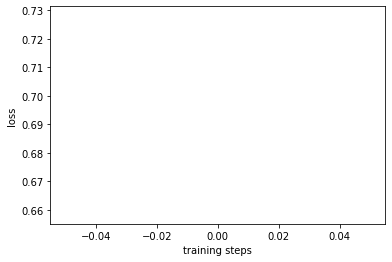

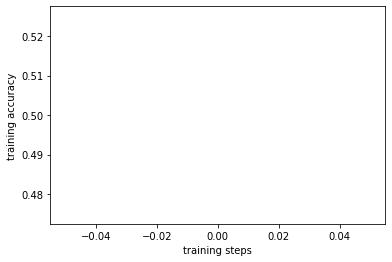

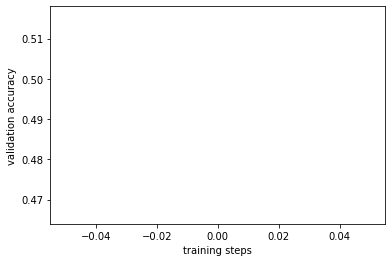

  6%|▌         | 100/1602.8125 [01:12<09:22,  2.67it/s]

Test accuracy = 0.689


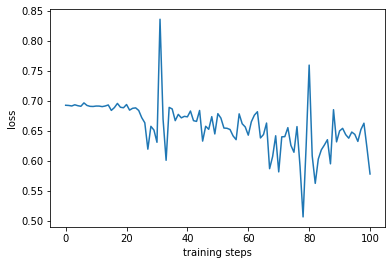

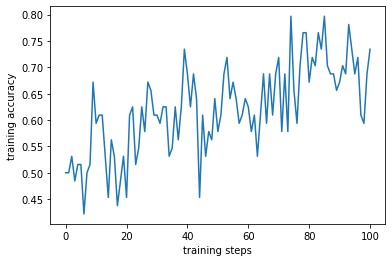

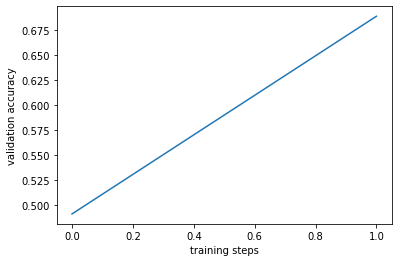

 12%|█▏        | 200/1602.8125 [02:25<08:45,  2.67it/s]

Test accuracy = 0.733


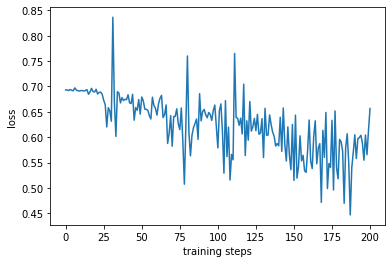

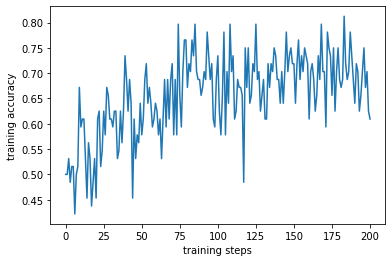

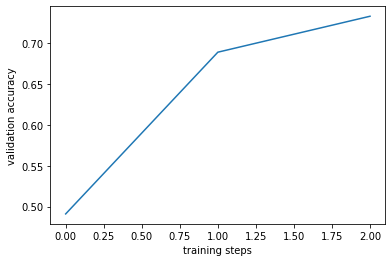

 19%|█▊        | 300/1602.8125 [03:37<08:07,  2.67it/s]

Test accuracy = 0.76


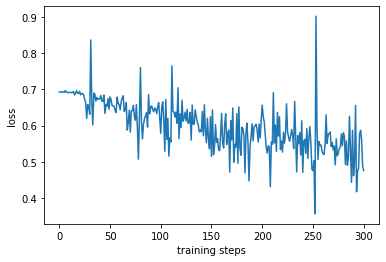

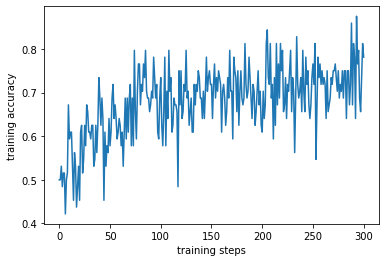

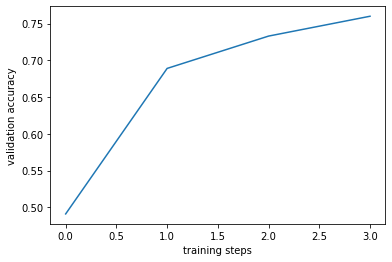

 25%|██▍       | 400/1602.8125 [04:50<07:30,  2.67it/s]

Test accuracy = 0.794


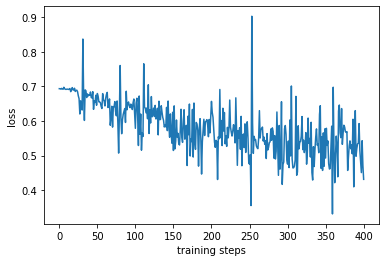

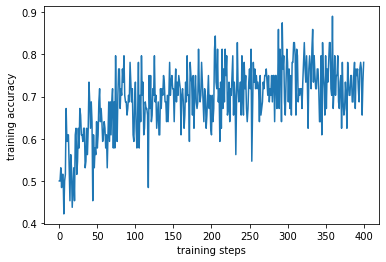

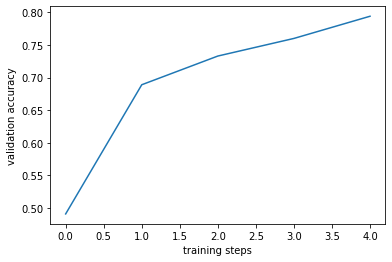

 31%|███       | 500/1602.8125 [06:02<06:53,  2.67it/s]

Test accuracy = 0.849


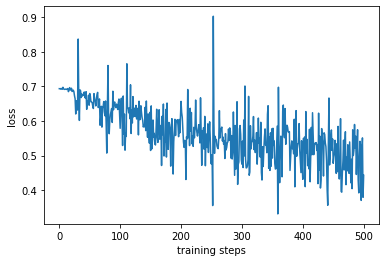

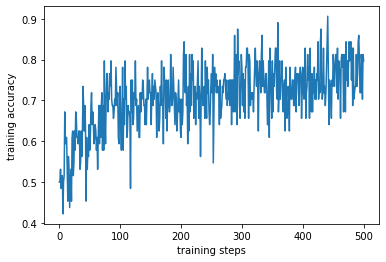

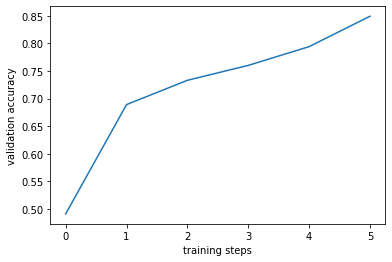

 37%|███▋      | 600/1602.8125 [07:15<06:14,  2.68it/s]

Test accuracy = 0.866


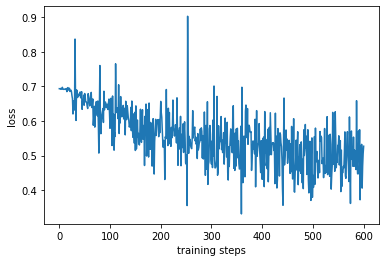

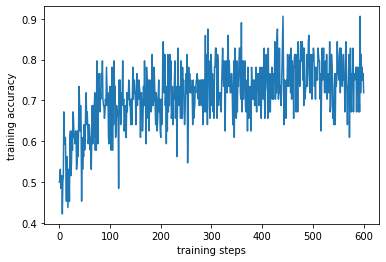

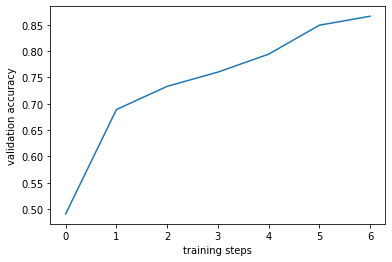

 44%|████▎     | 700/1602.8125 [08:27<05:36,  2.68it/s]

Test accuracy = 0.887


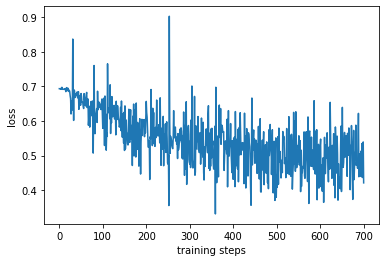

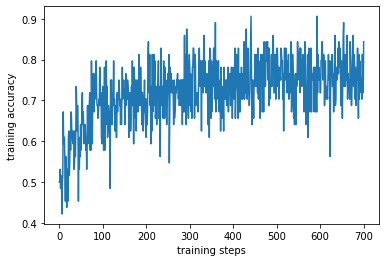

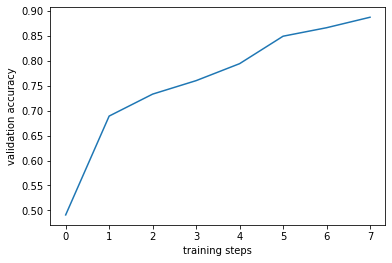

 50%|████▉     | 800/1602.8125 [09:39<05:00,  2.67it/s]

Test accuracy = 0.885


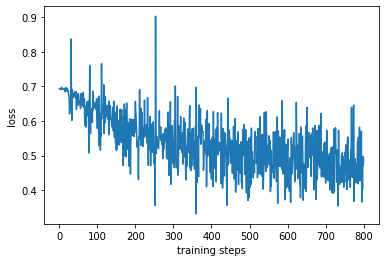

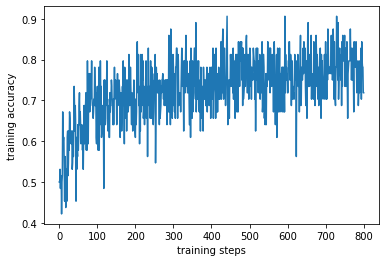

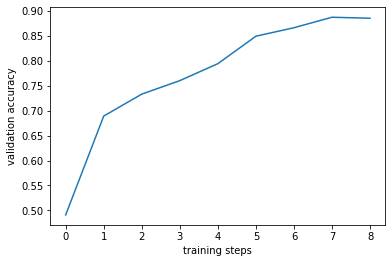

 56%|█████▌    | 900/1602.8125 [10:51<04:23,  2.67it/s]

Test accuracy = 0.89


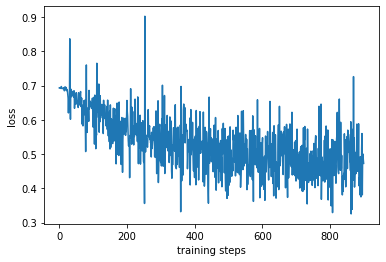

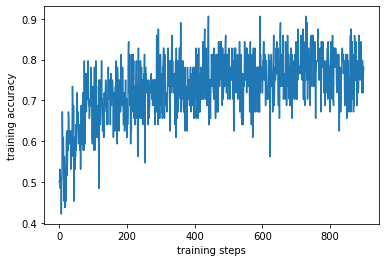

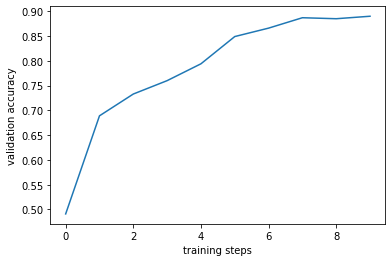

 62%|██████▏   | 1000/1602.8125 [12:04<03:44,  2.68it/s]

Test accuracy = 0.875


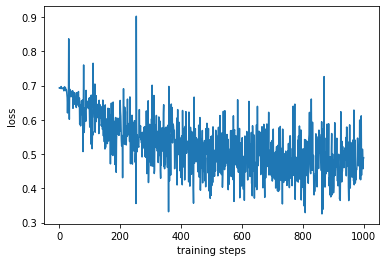

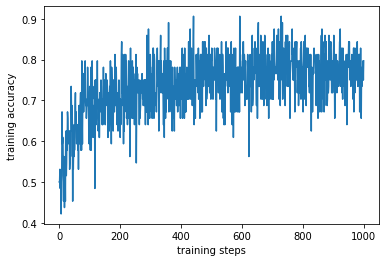

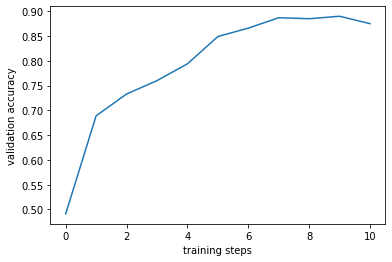

 69%|██████▊   | 1100/1602.8125 [13:16<03:07,  2.68it/s]

Test accuracy = 0.893


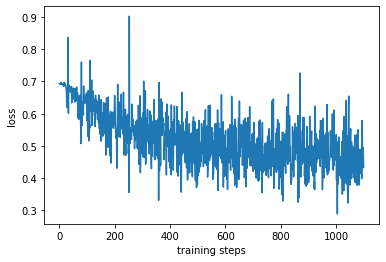

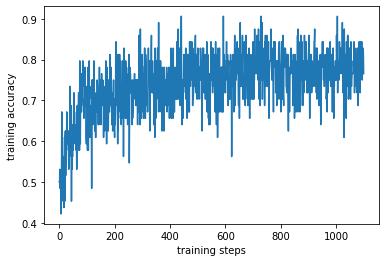

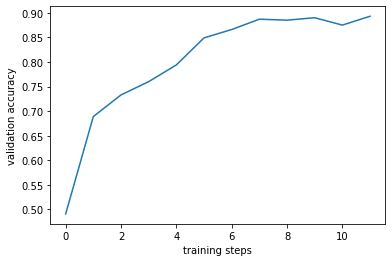

 75%|███████▍  | 1200/1602.8125 [14:28<02:30,  2.68it/s]

Test accuracy = 0.891


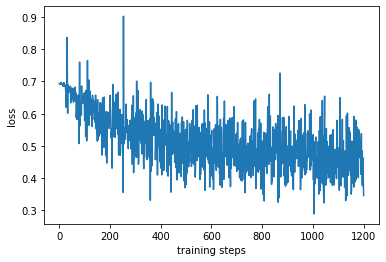

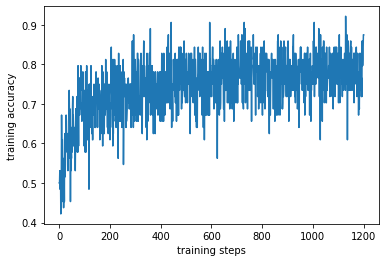

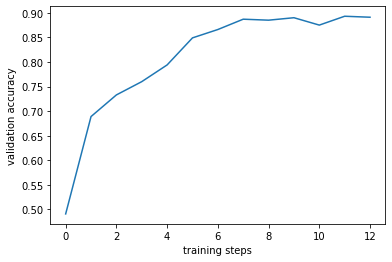

 81%|████████  | 1300/1602.8125 [15:40<01:53,  2.67it/s]

Test accuracy = 0.874


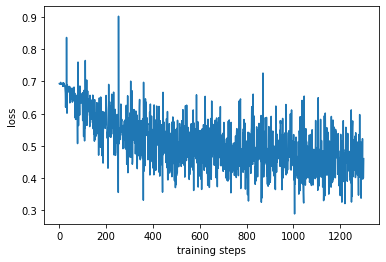

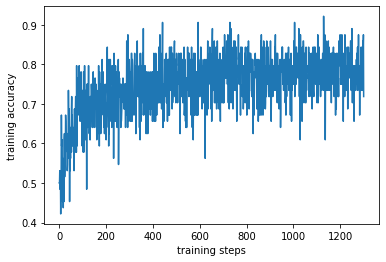

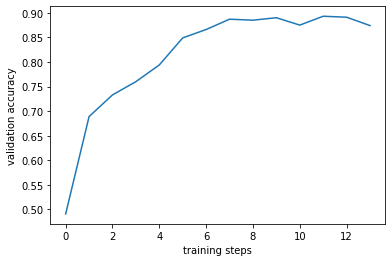

 87%|████████▋ | 1400/1602.8125 [16:52<01:15,  2.68it/s]

Test accuracy = 0.899


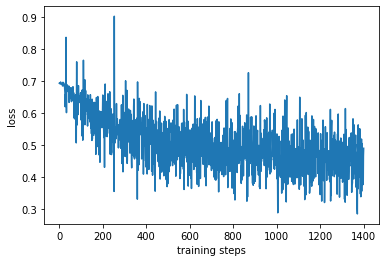

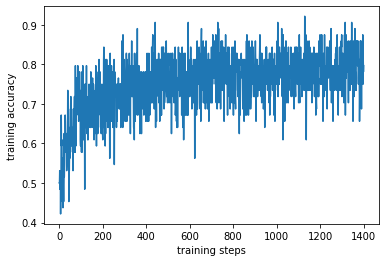

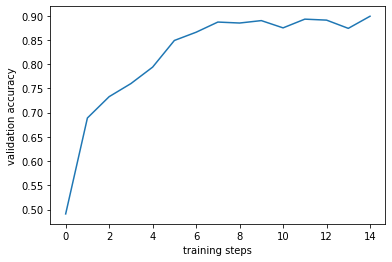

 94%|█████████▎| 1500/1602.8125 [18:04<00:38,  2.68it/s]

Test accuracy = 0.908


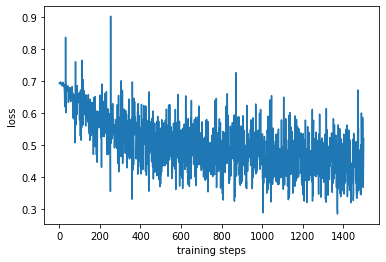

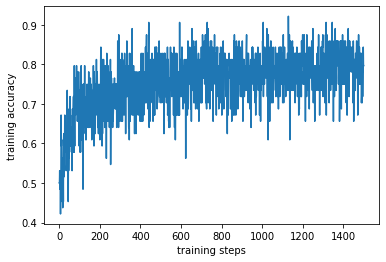

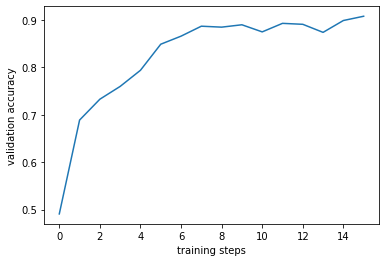

100%|█████████▉| 1600/1602.8125 [19:17<00:01,  2.68it/s]

Test accuracy = 0.908


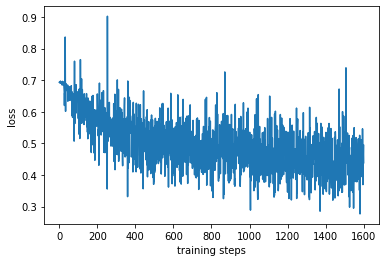

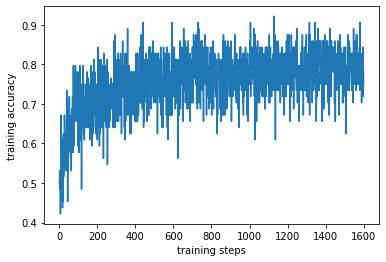

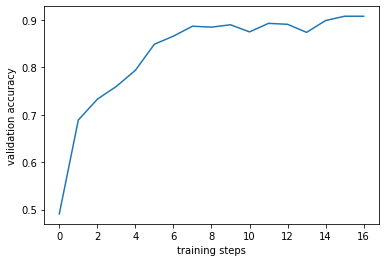

1603it [19:52,  1.34it/s]


In [0]:
# define model
model = oh2LSTMp_whole_text(units=512)
# train model on prepared dataset
(validation_accuracies, training_time) = train_one_hot(model, train_dataset, samples, batch_size, vocab_size, x_validation, y_validation, nb_classes=2, learning_rate=0.0005, epochs=1)

In [0]:
validation_accuracies[-1]

0.908

In [0]:
test_accuracy = test_model (x_test, y_test, model, vocab_size)

Test accuracy = 0.8798


In [0]:
test_model_fixed_size (x_test, y_test, model, vocab_size, chop_size=100, batch_size=batch_size)

Test accuracy = 0.8159772398843931


0.8159772398843931